<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Young_Adult_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Young Adult Group Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no 
    crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS

SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

- CURRENT RUN: ZNORM, MASK

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [2]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import plot_alphas
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

#Part I:
      Perform subject splitting into Young Adults
      Load saved pre-processed data from AWS 
                - or -
      Apply mask to .MAT data and filter data by labels
      Transform Data by:
          - Scaling data per run per subject based on normalization type (Z-score, Percent Signal Change or No Normalization)
          - Detrend the time series per run per subject
          - Concatenate the Training and Test Data (We can apply a Validation set but not needed since we performed Cross Validation on the Validation set prior for model tuning)
          - Train sklearn.svm.SVC with Params: C: 10; gamma: 'auto', class_balanced, and max_iter = 1000
          - Collect metrics: Accuracies, probabilities, classification report
          and save into a dictionary and uploading to S3. 

#### If you wish to skip ahead, please jump to **Part II** where we can load in the metrics data to visualize the brain data. Performance metric visualization is performed in a separate notebook called **Group_analysis.ipynb** in this current directory.  


## Load Unmasked Data from AWS
- normalize and transform data
- and obtain Young Adult subjects from last 19 subject IDs

In [ ]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
from_mat = 'unnorm' #unnorm
data_type = "YA_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key. // 1 is ROI
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Young Adult
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind) 
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

Number of subjects for Young Adult  19
Loading in masked data
CPU times: user 28.9 s, sys: 31.1 s, total: 60 s
Wall time: 1min 21s


## SVM Young Adult
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [ ]:
# get train, test data
train_ids = ya[:15]
#val_ids = ya[13:16]
test_ids = ya[15:19]

data_type = "YA_detrend"
group_sub_ids = (train_ids, False, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = False
runs_test = [1,2] #2 # grabds the third run
norm = "Detrend_Znorm" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization

print("Number of Young Adult training examples: ", len(train_ids))
#print("Number of Young Adult validation examples: ", len(val_ids))
print("Number of Young Adult testing examples: ", len(test_ids))
print(len(ya))

run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, norm, data_type, m_path_ind)

Number of Young Adult training examples:  15
Number of Young Adult testing examples:  4
19
Data will be detrended and znorm scaled by columns per run...
Crossvalidation already completed, do not need validation set.
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Final X Train data shape

#Part II:
      Load saved metrics for a given brain mask and extract 
      bmap 
      y labels 
      alpha values 

      If we are loading in the whole brain mask, we will also load in mask
      indices for regions of interest in which we want to apply as a mask
      overlay on top of the whole brain data. This will visually block out all
      areas of the brain other than the region of interest we wish to
      highlight. 
      
      - Plot the brain mask data using Nilearn's plot_img package
      - Visualize the decision function time series with y labels
      - Visualize a histogram of that represents essentially the decision
        function by plotting where voxels are in the positive or negative class
        and highlights the data where they have been mislabeled.
      - Save plots locally

## Visualization Analysis
- Load SVM pretrained model
- Load X train data and labels
- Check Support Vectors
- Create Alphas from dual coefficients/model weights and load into support vector indices
- Take the dot product of alphas and X train data and create a bmap
- Using the bmap we recreate the whole brain, 3d space using 3d mask indices and load information into this matrix (information are weights being applied to the X values by taking the dot product) 
- Use this information to visualize the areas of the brain that were learned by the SVM to be areas close to the decision boundary, areas thought of as either upregulating or downregulating

In [9]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "YA_detrend"
runs_train = [1, 2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key
metric_data = access_load_data(f'metrics/group_svm/{mask_type}/{data_type}_{runs_id}_{mask_type}_metrics.pkl', False)
print(metric_data.keys())


dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


#### Create Beta map for Visualization
- Create Alphas and Bmaps for Region of Interest
          We will look at:
            - Whole Brain Mask
            - medial Prefrontal Cortex
            - Nucleus Accumbens


In [10]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)

mask shape: (79, 95, 79)


> Whole Brain Interactive voxel map

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



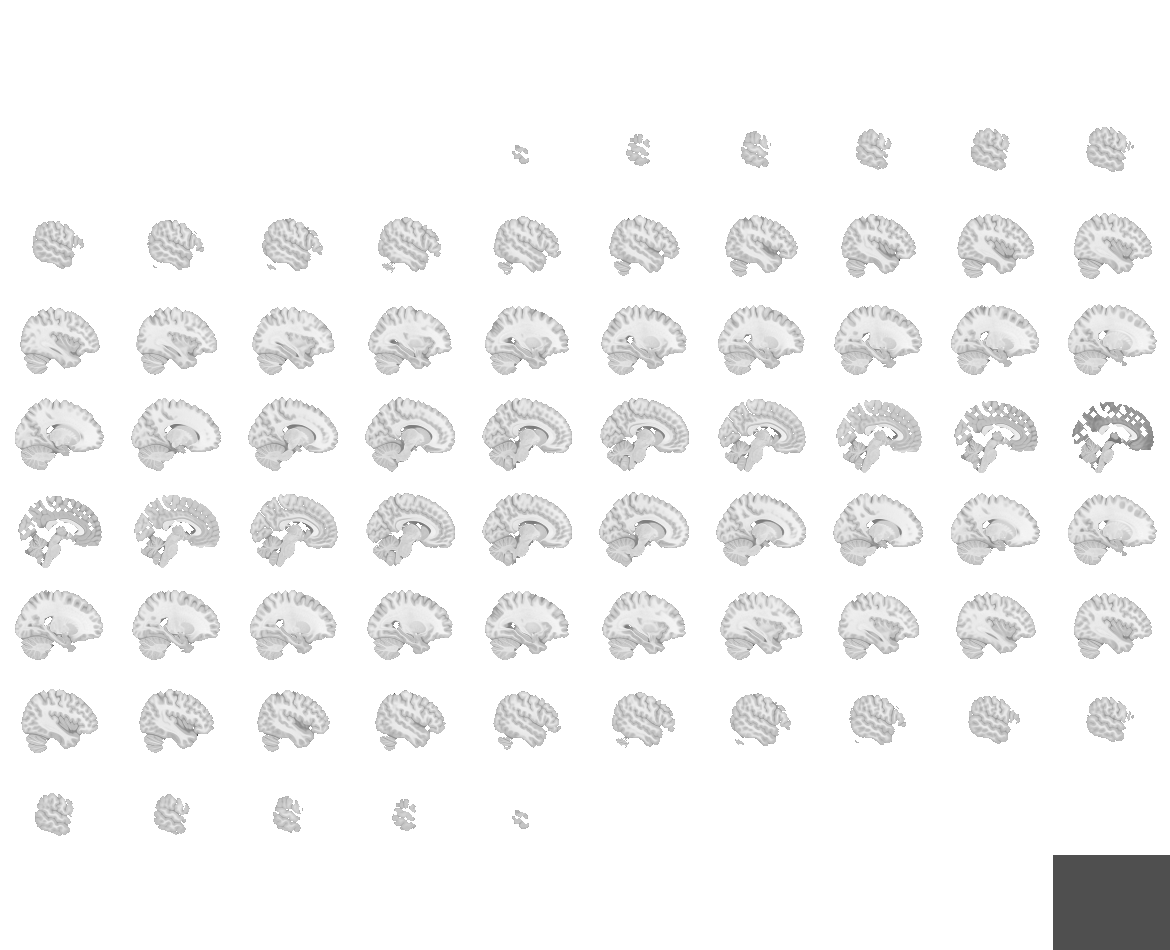
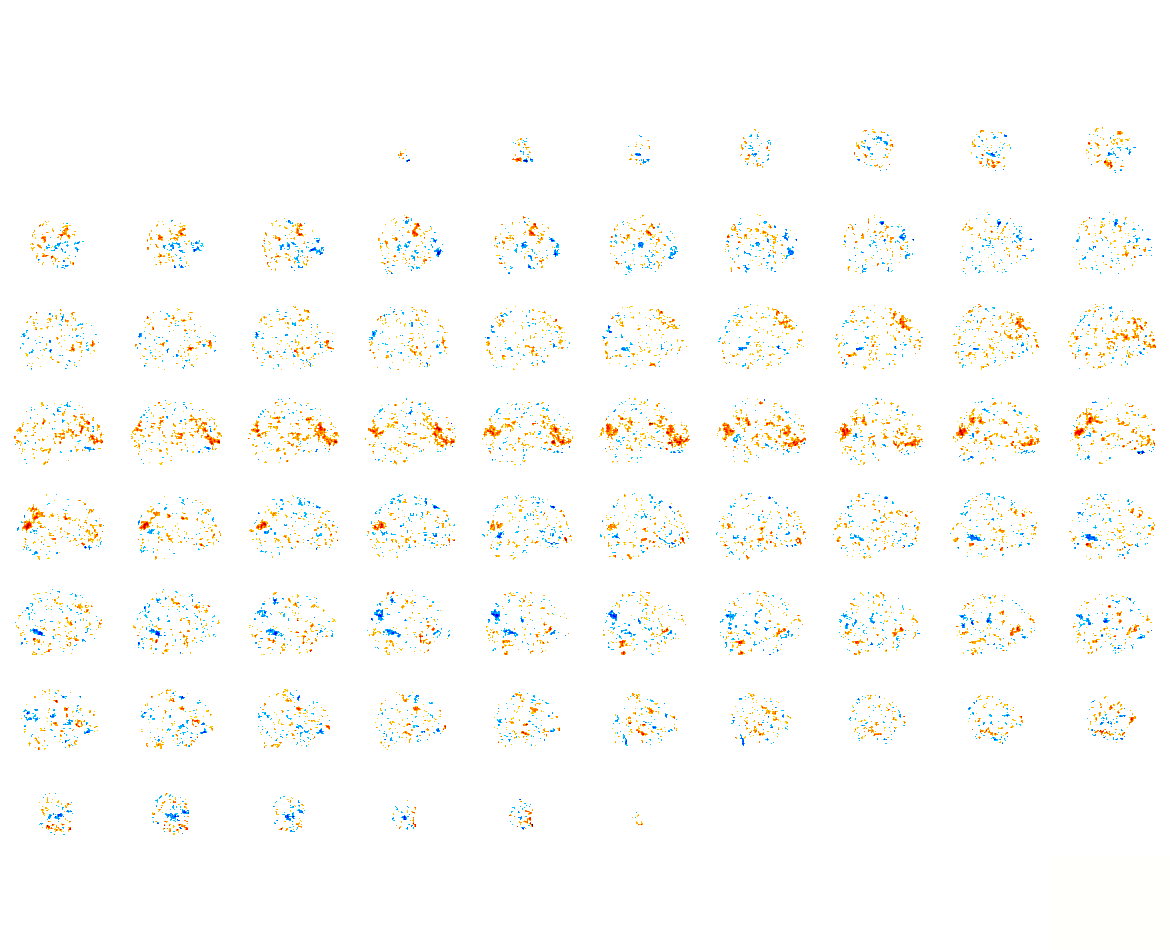

In [21]:
# Plot interactive maps     
html_view = plotting.view_img(metric_data['bmap3'][0], 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              title=f"Young Adult Whole Brain")#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_1.html')

> Isolating the Medial Prefrontal Cortex Region of Interest using data trained on whole brain

In [76]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'mPFC' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3pfc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3pfc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              title=f"Young Adult Medial PFC",
                              resampling_interpolationst = 'continuous'
                              )#{mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_roi}_1.html')

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))




> Isolate the Nucleus Accumbens in Whole Brain data



In [78]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'nacc_aal' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3nacc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3nacc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              title=f"Young Adult Nucleus Accumbens"
                              )#{mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_roi}_1.html')

mask shape: (79, 95, 79)


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))


> Let's Plot Whole Brain Slices 

In [100]:
# View Slices of the brain
# get bmaps for visualization
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "YA_detrend"
msk_type = 'Whole Brain'
bmap3 = metric_data['bmap3'][0]

outfile = True

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_plt_z_1.png"

  title = f"Young Adult {msk_type}"
  im = plotting.plot_img(bmap3, 
                          #bg_img = t1_image,
                          #title = title,
                          colorbar=True, 
                          black_bg = False, 
                          cut_coords = (-35,-20,0,20,35,50,65,70),
                          cmap='cold_white_hot', 
                          display_mode='z',
                          output_file = output_file
                          )
  """im.title(title, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='black', 
          bgcolor='w'
          )"""

> Plot Whole Brain with Thresholds
  - Score Percentile threshold 
  - Image Intensity threshold

In [120]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = True
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Young Adult {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Young Adult {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_stat_map(threshold_percentile_img,
                        title = title2 ,
                        bg_img = t1_image, 
                        display_mode='y', 
                        black_bg = False, 
                        cut_coords= (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        #annotate = False,
                        cmap = "cold_white_hot",
                        output_file=output_file1
                       )
"""im2.title(title2, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='black', 
          bgcolor='w'
          )"""

# Showing intensity threshold image
im3 = plotting.plot_stat_map(threshold_value_img, 
                        title = title3,
                        bg_img = t1_image, 
                        black_bg = False, 
                        display_mode='y', 
                        cut_coords= (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file2
                       )
"""im3.title(title3, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='black', 
          bgcolor='w'
          )"""

"im3.title(title3, \n          x=0.01, \n          y=0.99, \n          size=15, \n          color='black', \n          bgcolor='w'\n          )"

> Plot Alphas and Decision Function values

In [ ]:
def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')


# Plot the time series with alpha signals and labels
title = f"Young Adult Group {mask_type} Last"

timepoints = [(200, -2, 2)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)




In [ ]:
"""
# Plotting all slices in brain
title = f'Threshold image with intensity value for Young Adult {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullsliceCOLDhot.png"
plotting.plot_img(bmap3, 
                  #threshold_percentile_img, 
                  bg_img = t1_image, 
                  #display_mode='z', 
                  cut_coords=(1, 55, -22), 
                  annotate = True,
                  #title=title, 
                  colorbar=True,
                  cmap = "cold_hot",
                  output_file=output_file3
                  )"""

In [ ]:
#metric = access_load_data('metrics/group_svm/masksubmPFC/YA_detrend_[2, 3]_masksubmPFC_metrics.pkl', False)
dfunc = metric['test_dfunc'][0]
yt = metric['y_t'][0]
probs = metric['test_probs'][0]
dfprob = pd.DataFrame(probs)
dfprob

,0
0,0.456223
1,0.780330
2,0.880992
3,0.463451
4,0.651521
...,...
667,0.364860
668,0.357095
669,0.525910
670,0.417950


In [ ]:
df = pd.DataFrame(dfunc)
df.rename(columns={0: "scores"}, inplace = True)
df['time'] = [i for i in range(len(df['scores']))]
df
df['color'] = 'green'
df['color'].loc[df['scores'] < 0] = 'blue'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df['yt'] = yt
df
#df.loc[df['First Season'] > 1990, 'First Season'] = 1

,scores,time,color,yt
0,-0.051221,0,blue,1
1,0.264410,1,green,1
2,0.424699,2,green,1
3,-0.044845,3,blue,1
4,0.124052,4,green,1
...,...,...,...,...
667,-1.000000,667,blue,0
668,-1.000000,668,blue,0
669,-1.000000,669,blue,0
670,-1.000000,670,blue,0


In [ ]:
df['yt'] = np.where(
   df['yt'] ==0 , -1, df['yt']
   )
df

,scores,time,color,yt
0,-0.051221,0,blue,1
1,0.264410,1,green,1
2,0.424699,2,green,1
3,-0.044845,3,blue,1
4,0.124052,4,green,1
...,...,...,...,...
667,-1.000000,667,blue,-1
668,-1.000000,668,blue,-1
669,-1.000000,669,blue,-1
670,-1.000000,670,blue,-1


In [ ]:
### Altair Decision Boundary
import altair as alt

alt.layer(
    alt.Chart().mark_line().encode(x = 'time:T', 
                                   y = alt.Y('yt:Q')),
                                   #color = 'label_color:N'),
    alt.Chart().mark_line().encode(color = 'score_color:N'),
    alt.Chart().mark_line().encode(color='color:N'),
    data=df[:100]
).transform_calculate(
    score_color="datum.scores > 0.0 & datum.scores < 0.0",
    #label_color = "datum.yt > 0.0 & datum.yt < 0.0"
).encode(
    x='time:T',
    y=alt.Y('scores:Q', impute={'value': None})
)

alt.LayerChart(...)

In [ ]:
# View Slices of the brain
# get bmaps for visualization
#title = f"Young Adult {mask_type}"
output_file = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_statmap_z_1.png"

plotting.plot_stat_map(bmap3, 
                       bg_img = t1_image,
                       colorbar=True, 
                       cmap='hot', 
                       display_mode='z',
                       #title=f"{title}",
                       output_file = output_file
                       )

In [ ]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)
output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


# Plotting image thresholded by percentile
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'98th percentile Signal threshold Young Adult {mask_type}',
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file1
                       )

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'Image intensity threshold Young Adult {mask_type}', 
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file2
                       )

In [ ]:
def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')

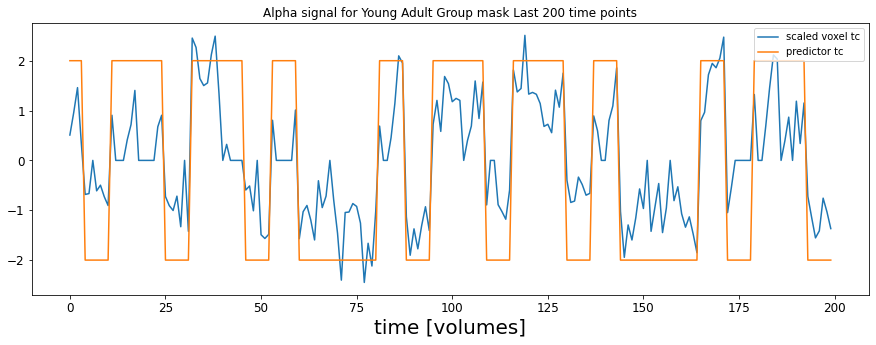

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the time series with alpha signals and labels
title = f"Young Adult Group {mask_type} Last"

timepoints = [(200, -2, 2)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)

In [ ]:
# Plot interactive maps     
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              #cmap = 'hot', 
                              cut_coords=[-10, 13, -8],
                              title=f"Young Adult {mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_1.html')

In [ ]:
# Plotting all slices in brain
title = f'Threshold image with intensity value for Young Adult {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullsliceCOLDhot.png"
plotting.plot_stat_map(bmap3, #threshold_percentile_img, 
                       bg_img = t1_image, 
                       #display_mode='z', 
                       cut_coords=(1, 55, -22), 
                       annotate = True,
                       #title=title, 
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file3
                       )

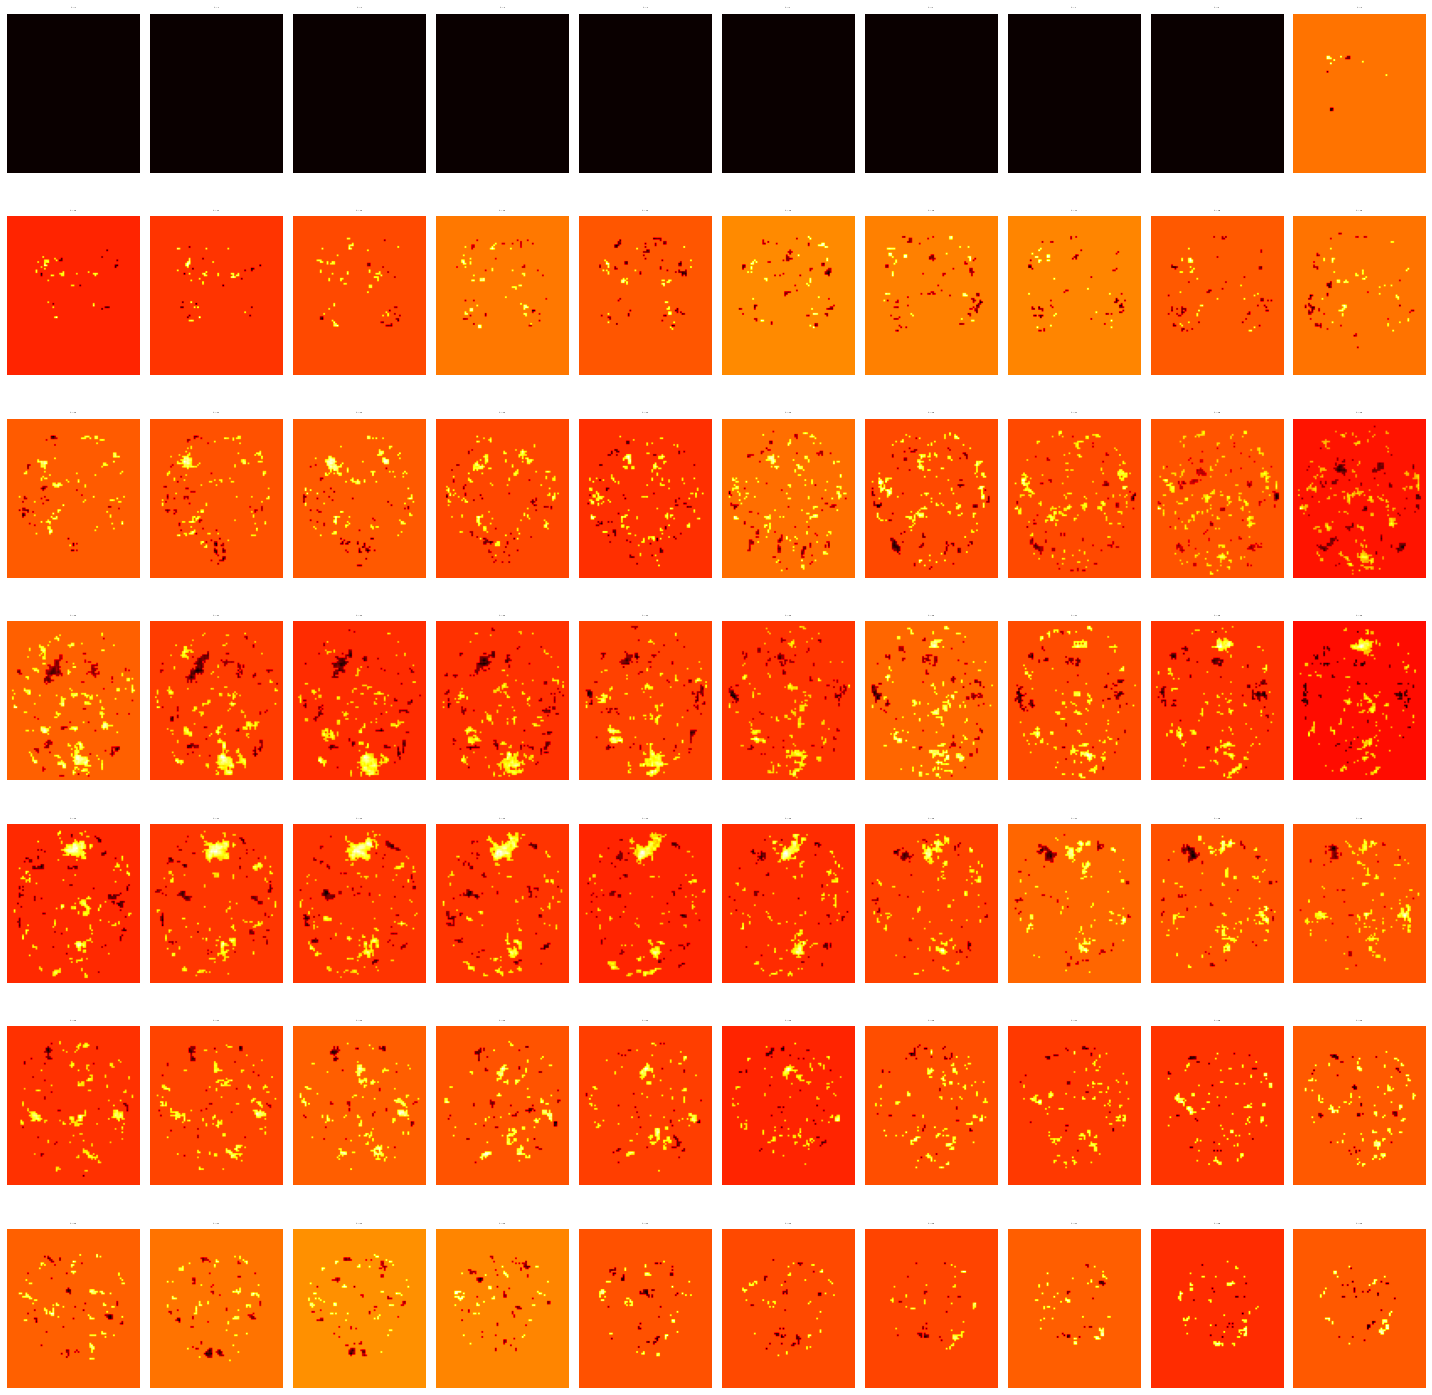

In [ ]:
fig, axes = plt.subplots(ncols=10, nrows=7, figsize=(20, 20))  # 70 slices
# Loop over the first 70 slices
for t, ax in enumerate(axes.flatten()):   
    ax.imshow(bmap2_3[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

## Predict Young Adult Brain states on model trained with Adolescent Data

In [ ]:
# get train, test val data
train_ids = ya[:13]
val_ids = ya[13:16]
test_ids = ya[16:20]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
model_type = "Adolescent"
data_type = "YA_Adol"
runs_id = [i+1 for i in runs_train]

print("Number of Youth training examples: ", len(train_ids))
print("Number of Youth validation examples: ", len(val_ids))
print("Number of Youth testing examples: ", len(test_ids))
print(len(ya))

X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)


# Load Adolescent model
model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
print(model_dict.keys())
clf = model_dict['model'][0]


metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type, model_type)

Number of Youth training examples:  13
Number of Youth validation examples:  3
Number of Youth testing examples:  3
19
Normalizing Each based on RUNS...
Final X Train data shape (2184, 237979)
Final y Train data shape  (2184,)
Final X Val data shape (504, 237979)
Final y Val data shape  (504,)
Final X Test data shape (504, 237979)
Final y Test data shape  (504,)
dict_keys(['model', 'X_train', 'y_train'])
Predicting on Validation set...
Validation Accuracy: 0.7599206349206349
Predicting on Test set...
Test Accuracy: 0.8075396825396826
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       252
           1       0.73      0.83      0.78       252

    accuracy                           0.76       504
   macro avg       0.77      0.76      0.76       504
weighted avg       0.77      0.76      0.76       504

Classification report for whole_brain test_classreport
              pre

True

In [ ]:
# Load Adolescent model
model_type = "YA_YA"
data_type = "YA_YA"
runs_train = [1,2]
runs_id = [i+1 for i in runs_train]
mask_type = "mask"
znorm = "RUNS"
#model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
#print(model_dict.keys())
#clf = model_dict['model'][0]

X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, znorm)
#metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type)

Normalizing Each based on RUNS...
Final X Train data shape (2184, 237979)
Final y Train data shape  (2184,)
Final X Val data shape (504, 237979)
Final y Val data shape  (504,)
Final X Test data shape (504, 237979)
Final y Test data shape  (504,)


In [ ]:
d = clf.support_vectors_
d.shape

(1602, 237979)

In [ ]:
y_decision_score = clf.decision_function(X_t)


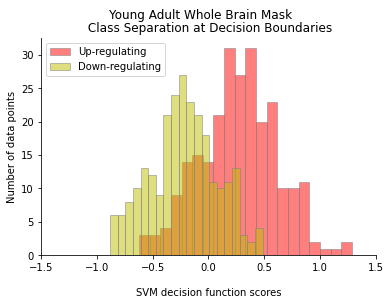

In [ ]:
y_decision_score = clf.decision_function(X_t)
y_negative_decision_score = y_decision_score[y_t == 0]
y_positive_decision_score = y_decision_score[y_t == 1]


ax = plt.subplot()
# plot the two histograms
plt.hist(y_positive_decision_score, bins = 20, alpha=0.5, label='Up-regulating', color='r', histtype='bar', ec='gray')
plt.hist(y_negative_decision_score, bins = 20, alpha=0.5, label='Down-regulating', color='y', histtype='bar', ec='gray')
ax.spines["right"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
#ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlim(-1.5, 1.5)
plt.legend(loc = "upper left")
plt.xlabel('\nSVM decision function scores')
plt.ylabel('Number of data points')
plt.suptitle("Young Adult Whole Brain Mask \n\n")
plt.title("\n Class Separation at Decision Boundaries")
plt.savefig('/content/gdrive/MyDrive/YA_decision_hist2.png', dpi=200, transparent=True)
plt.show()


In [ ]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Young Adult Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "\nUnnormalized": [.49, .54, .51, .49, .50, .51],
              "\nPSC": [.49, .61, .60, .62, .50, .56 ],
              "\nPSC+ZNorm": [.77, .76, .82, .79, .80, .79],
              "\nZNorm": [.77, .75, .82, .81, .80, .79]}

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Young Adult Train run 2/Test run 3", inplace = True)
df

,\nUnnormalized,\nPSC,\nPSC+ZNorm,\nZNorm
Cross Validation Young Adult Train run 2/Test run 3,,,,
1,0.49,0.49,0.77,0.77
2,0.54,0.61,0.76,0.75
3,0.51,0.60,0.82,0.82
4,0.49,0.62,0.79,0.81
5,0.50,0.50,0.80,0.80
Average,0.51,0.56,0.79,0.79


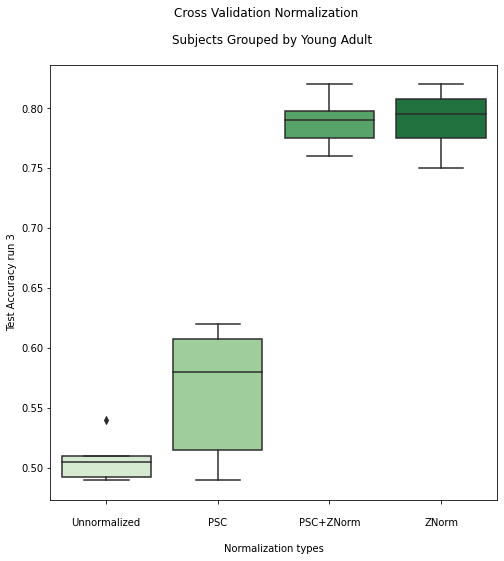

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
sns.boxplot(data = df, palette="Greens")
plt.xlabel("\nNormalization types")
plt.ylabel("Test Accuracy run 3")
plt.suptitle("Cross Validation Normalization")
plt.title("Subjects Grouped by Young Adult \n")
plt.savefig('/content/gdrive/MyDrive/YA_norm_box.png', dpi=200, transparent=True)
plt.show()

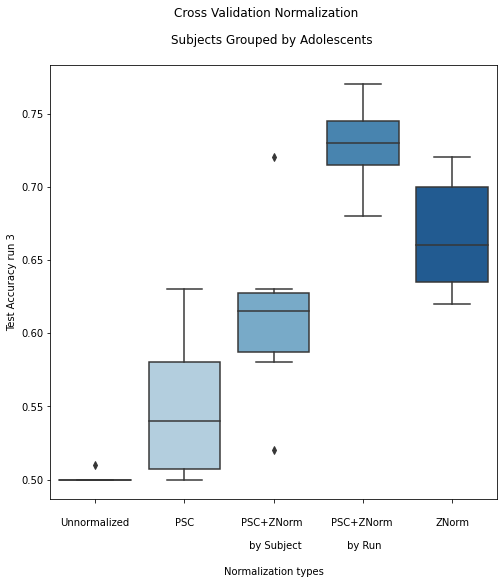

In [ ]:
## Cross Validation accuracy scores recorded

dictionarya = {"Cross Validation Adolescent Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "\nUnnormalized": [.50, .51, .50, .50, .50, .50],
              "\nPSC": [.53, .63, .50, .50, .59, .55 ], 
              "\nPSC+ZNorm \n\n by Subject": [.63, .72, .62, .58, .52, .61], 
              "\nPSC+ZNorm \n\n by Run": [.68, .75, .73, .71, .77, .73], 
              "\nZNorm": [.62, .71, .72, .65, .63, .67]
              }

dfa = pd.DataFrame(dictionarya)
dfa.set_index("Cross Validation Adolescent Train run 2/Test run 3", inplace = True)
plt.figure(figsize = (8, 8))
sns.boxplot(data = dfa, palette="Blues")
plt.xlabel("\nNormalization types")
plt.ylabel("Test Accuracy run 3")
sns.color_palette("tab10")
plt.suptitle("Cross Validation Normalization")
plt.title("Subjects Grouped by Adolescents \n")
plt.savefig('/content/gdrive/MyDrive/AD_norm_box.png', dpi=200, transparent=True)
plt.show()


In [ ]:
df

,Unnormalized,PSC,PSC + Z Norm,Z Norm
Cross Validation Young Adult Train run 2/Test run 3,,,,
1,0.49,0.49,0.77,0.77
2,0.54,0.61,0.76,0.75
3,0.51,0.60,0.82,0.82
4,0.49,0.62,0.79,0.81
5,0.50,0.50,0.80,0.80
Average,0.51,0.56,0.79,0.79
